# XGBoost for Classification Problem
Dataset: `bc_data.csv`

In this problem, we are predicting if a sample of tissues is cancerous (yes) or not (no). THe response variable is named outcome.

## Step 0 — Load Data and EDA (we skip for now)

In [1]:
# Imports
import os
import numpy as np
import pandas as pd

# Modeling
# train_test_split:   splits data into training and testing subsets
# KFold:              defines cross-validation folds (e.g., 5-fold CV)
from sklearn.model_selection import train_test_split, StratifiedKFold

# Pipeline:           chains preprocessing steps (scaling, encoding, model) into one object
#                     ensures consistent transformations during training and prediction
from sklearn.pipeline import Pipeline

#GridSearchCV:     provides the cv engine for trees which do not have one built in
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

# Metrics:               roc_auc_score gives a single number (AUC) to summarize model performance
#                        roc_curve gives the points to plot the ROC curve
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt  

#!pip install xgboost if not installed
from xgboost import XGBClassifier
# Reproducibility seeds
np.random.seed(87)  # used for train/test split

In [19]:
# Expect the file to be in the same folder as this notebook
df = pd.read_csv('bc_data.csv' )
df.shape

(600, 10)

In [20]:
df.describe(include='all')

,Thickness_of_Clump,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Outcome
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380
mean,5.410000,4.121667,4.195000,3.763333,4.293333,4.500000,4.495000,3.811667,2.093333,NaN
std,2.798503,2.936194,2.926531,2.782726,2.279462,3.476129,2.438555,3.031751,1.763464,NaN
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN
25%,3.000000,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,1.000000,NaN
50%,5.000000,3.000000,3.000000,3.000000,4.000000,3.000000,4.000000,3.000000,2.000000,NaN
75%,7.250000,6.000000,6.000000,5.000000,5.000000,9.000000,6.000000,5.000000,2.000000,NaN


In [21]:
df['Outcome'].value_counts()# summary stats

Outcome
No     380
Yes    220
Name: count, dtype: int64

In [22]:
# Turn categorical variables into dummy (0/1) columns
X = pd.get_dummies(df.drop(columns=["Outcome"]), drop_first=True)  

# Target variable
Y = df["Outcome"]

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.3,     # 30% test, 70% train
    random_state=99,   # reproducibility
    shuffle=True       # shuffle before splitting
)

# Check shapes
X_train.shape, X_test.shape

((420, 9), (180, 9))

In [23]:
# Determine classes and ordering
classes = pd.unique(pd.Series(Y_train).dropna())
classes

array(['No', 'Yes'], dtype=object)

In [24]:
# Convert to 0,1 for XGBoost 
mapping = {c: int(c == "Yes") for c in classes}

Y_train = pd.Series(Y_train).map(mapping).to_numpy()
Y_test = pd.Series(Y_test).map(mapping).to_numpy()

In [25]:

# 1) CV split (same as before)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)


# 3) Pipeline with XGBoost model
xgb_pipe = Pipeline([
    ("model", XGBClassifier(
        objective="binary:logistic",
        n_jobs=-1,          # use all cores
        eval_metric="auc",  # pairs well with scoring="roc_auc"
        tree_method="hist", # fast CPU histogram algorithm (use "gpu_hist" if you have a GPU)
        random_state=99
    ))
])

# 4) Hyperparameter grid (reasonable, compact search)
param_grid = {
    "model__n_estimators": [400, 800],
    "model__max_depth":    [4, 6, 8],
    "model__learning_rate":[0.05, 0.1],
    "model__subsample":    [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__min_child_weight": [1, 3]
}

# 5) Cross-validated grid search (same scoring)
xgb_cv = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True
)

# 6) Fit with per-sample weights
xgb_cv.fit(X_train, Y_train)

print("Positive class used by AUC:", xgb_cv.best_estimator_.named_steps["model"].classes_[1])
print("Best params selected by CV:", xgb_cv.best_params_)
print("Best CV ROC-AUC:", round(xgb_cv.best_score_, 3))

Positive class used by AUC: 1
Best params selected by CV: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__min_child_weight': 3, 'model__n_estimators': 400, 'model__subsample': 0.8}
Best CV ROC-AUC: 0.99


                       feature  importance
1         Cell_Size_Uniformity    0.358867
5                  Bare_Nuclei    0.288858
2        Cell_Shape_Uniformity    0.180413
7              Normal_Nucleoli    0.047688
0           Thickness_of_Clump    0.038595
6              Bland_Chromatin    0.037811
8                      Mitoses    0.022255
3            Marginal_Adhesion    0.013014
4  Single_Epithelial_Cell_Size    0.012499


<Figure size 800x600 with 0 Axes>

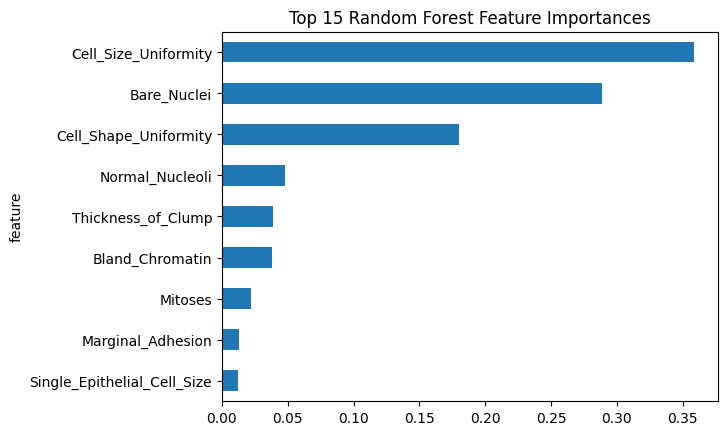

In [26]:
# Get best fitted model from GridSearchCV
best_xgb = xgb_cv.best_estimator_.named_steps["model"]

# Get feature importances (aligned with columns of X_train)
importances = best_xgb.feature_importances_
features = X_train.columns

# Put in DataFrame for clarity
feat_imp = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp.head(15))  # top 15 features

# Optional: plot top features
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()


In [27]:
#determine class order of your response variable
classes = xgb_cv.best_estimator_.named_steps["model"].classes_
print("Class order:", classes)

Class order: [0 1]


In [28]:

pos_idx = list(classes).index(1)   #Put in the class you are trying to predict
proba = xgb_cv.predict_proba(X_test)[:, pos_idx]

ROC AUC (test): 0.981


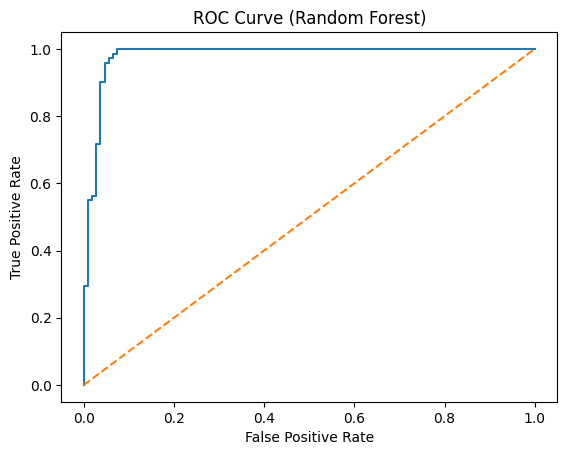

In [29]:
# ROC curve + AUC (tell roc_curve which label is positive)
pos_label=1 
fpr, tpr, _ = roc_curve(Y_test, proba, pos_label=pos_label)
roc_auc = roc_auc_score((Y_test == pos_label).astype(int), proba)
print(f"ROC AUC (test): {roc_auc:.3f}")
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.show()

In [30]:
#!pip install shap   # Install SHAP library if not already installed
import shap          

# Create SHAP explainer for tree-based models (e.g., XGBoost, LightGBM, RandomForest)
explainer   = shap.TreeExplainer(best_xgb)

# Compute SHAP values for the training set
# Each value shows how much a feature pushes a prediction toward class 1 (positive) or class 0 (negative)
shap_values = explainer.shap_values(X_train)

# Overall PLot Beeswarm plot: this shows both which features matter most and the direction of their influence

shap.summary_plot(shap_values, X_train, max_display=15, show=True)

ImportError: Numba needs NumPy 2.2 or less. Got NumPy 2.3.